In [1]:
import time
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas import DataFrame
import os
import random
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt
from sklearn import preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from collections import deque
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, CuDNNLSTM, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import History 
from entropy import *

Using TensorFlow backend.


In [2]:
TIME_STEPS = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "P_avg"
EPOCHS = 10  # how many passes through our data
SEQ_LEN = 60
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model
pd.__version__

'0.23.4'

In [3]:
main_df = pd.read_csv('Updated_Basic_Data.csv')

In [4]:
# R80711

main_df_R80711 = main_df[main_df.Wind_turbine_name == 'R80711']
main_df_R80711 = main_df_R80711.reset_index()[['Wa_avg', 'Wa_min', 'Wa_max',
                                               'Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws_avg', 'Ws_min', 'Ws_max',
                                               'Rs_avg', 'Rs_min', 'Rs_max', 
                                               'P_avg',  'P_min', 'P_max']]

main_df_R80721 = main_df[main_df.Wind_turbine_name == 'R80721']
main_df_R80721 = main_df_R80721.reset_index()[['Wa_avg', 'Wa_min', 'Wa_max',
                                               'Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws_avg', 'Ws_min', 'Ws_max',
                                               'Rs_avg', 'Rs_min', 'Rs_max', 
                                               'P_avg',  'P_min', 'P_max']]

main_df_R80736 = main_df[main_df.Wind_turbine_name == 'R80736']
main_df_R80736 = main_df_R80736.reset_index()[['Wa_avg', 'Wa_min', 'Wa_max',
                                               'Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws_avg', 'Ws_min', 'Ws_max',
                                               'Rs_avg', 'Rs_min', 'Rs_max', 
                                               'P_avg',  'P_min', 'P_max']]

main_df_R80790 = main_df[main_df.Wind_turbine_name == 'R80790']
main_df_R80790 = main_df_R80790.reset_index()[['Wa_avg', 'Wa_min', 'Wa_max',
                                               'Ws1_avg', 'Ws1_min', 'Ws1_max', 'Ws2_avg', 'Ws2_min', 'Ws2_max', 'Ws_avg', 'Ws_min', 'Ws_max',
                                               'Rs_avg', 'Rs_min', 'Rs_max', 
                                               'P_avg',  'P_min', 'P_max']]

In [5]:
def train_test_split(data):
    '''
    Function that splits the dataframe into training and test data via an 80:20 split
    '''
    Index = sorted(data.index.values) 
    Last20pct = Index[-int(0.2*len(Index))]

    validation_data = data[(data.index >= Last20pct)]
    data = data[(data.index < Last20pct)]
    return validation_data, data

def scale_data(data,column,scaler):
    '''
    Column should be literal for funciton to work 
    '''
    data_form = data[column].values.reshape((len(data), 1))
    scaled_data = scaler.transform(data_form)
    return scaled_data

In [6]:
# Test train split using 20 80 in hopes of more better validation
Test_R80711, Train_R80711 = train_test_split(main_df_R80711)
#
Test_R80721, Train_R80721 = train_test_split(main_df_R80721)
#
Test_R80736, Train_R80736 = train_test_split(main_df_R80736)
#
Test_R80790, Train_R80790 = train_test_split(main_df_R80790)

In [7]:
# First fit the scalers to the data then transform the data using said scalers using the scale_data function
Wa_scaler = MinMaxScaler(feature_range=(0,1))
Scaler_fit_Wa_avg = Train_R80711['Wa_avg'].values.reshape(len(Train_R80711['Wa_avg']),1)
Wa_scaler.fit(Scaler_fit_Wa_avg)
Ws_scaler = MinMaxScaler(feature_range=(0,1))
Scaler_fit_Ws_avg = Train_R80711['Ws_avg'].values.reshape(len(Train_R80711['Ws_avg']),1)
Ws_scaler.fit(Scaler_fit_Ws_avg)
Rs_scaler = MinMaxScaler(feature_range=(0,1))
Scaler_fit_Rs_avg = Train_R80711['Rs_avg'].values.reshape(len(Train_R80711['Rs_avg']),1)
Rs_scaler.fit(Scaler_fit_Rs_avg)
P_scaler  = MinMaxScaler(feature_range=(0,1))
Scaler_fit_P_avg = Train_R80711['P_avg'].values.reshape(len(Train_R80711['P_avg']),1)
P_scaler.fit(Scaler_fit_P_avg)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [8]:
# R80711
# Training Data scaled

Scaled_Wa_avg_R80711 = scale_data(Train_R80711,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80711 = scale_data(Train_R80711,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80711 = scale_data(Train_R80711,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80711 = scale_data(Train_R80711,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80711 = scale_data(Train_R80711,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80711 = scale_data(Train_R80711,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80711 = scale_data(Train_R80711,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80711 = scale_data(Train_R80711,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80711 = scale_data(Train_R80711,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80711 = scale_data(Train_R80711,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80711 = scale_data(Train_R80711,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80711 = scale_data(Train_R80711,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80711 = scale_data(Train_R80711,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80711 = scale_data(Train_R80711,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80711 = scale_data(Train_R80711,'Rs_max',Rs_scaler)
Scaled_P_avg_R80711 = scale_data(Train_R80711,'P_avg',P_scaler)
Scaled_P_min_R80711 = scale_data(Train_R80711,'P_min',P_scaler)
Scaled_P_max_R80711 = scale_data(Train_R80711,'P_max',P_scaler)

# Testing Data scaled

Scaled_Wa_avg_R80711_Test = scale_data(Test_R80711,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80711_Test = scale_data(Test_R80711,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80711_Test = scale_data(Test_R80711,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80711_Test = scale_data(Test_R80711,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80711_Test = scale_data(Test_R80711,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80711_Test = scale_data(Test_R80711,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80711_Test = scale_data(Test_R80711,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80711_Test = scale_data(Test_R80711,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80711_Test = scale_data(Test_R80711,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80711_Test = scale_data(Test_R80711,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80711_Test = scale_data(Test_R80711,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80711_Test = scale_data(Test_R80711,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80711_Test = scale_data(Test_R80711,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80711_Test = scale_data(Test_R80711,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80711_Test = scale_data(Test_R80711,'Rs_max',Rs_scaler)
Scaled_P_avg_R80711_Test = scale_data(Test_R80711,'P_avg',P_scaler)
Scaled_P_min_R80711_Test = scale_data(Test_R80711,'P_min',P_scaler)
Scaled_P_max_R80711_Test = scale_data(Test_R80711,'P_max',P_scaler)

In [9]:
# R80721
# Training Data scaled

Scaled_Wa_avg_R80721 = scale_data(Train_R80721,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80721 = scale_data(Train_R80721,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80721 = scale_data(Train_R80721,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80721 = scale_data(Train_R80721,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80721 = scale_data(Train_R80721,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80721 = scale_data(Train_R80721,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80721 = scale_data(Train_R80721,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80721 = scale_data(Train_R80721,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80721 = scale_data(Train_R80721,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80721 = scale_data(Train_R80721,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80721 = scale_data(Train_R80721,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80721 = scale_data(Train_R80721,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80721 = scale_data(Train_R80721,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80721 = scale_data(Train_R80721,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80721 = scale_data(Train_R80721,'Rs_max',Rs_scaler)
Scaled_P_avg_R80721 = scale_data(Train_R80721,'P_avg',P_scaler)
Scaled_P_min_R80721 = scale_data(Train_R80721,'P_min',P_scaler)
Scaled_P_max_R80721 = scale_data(Train_R80721,'P_max',P_scaler)

# Testing Data scaled

Scaled_Wa_avg_R80721_Test = scale_data(Test_R80721,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80721_Test = scale_data(Test_R80721,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80721_Test = scale_data(Test_R80721,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80721_Test = scale_data(Test_R80721,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80721_Test = scale_data(Test_R80721,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80721_Test = scale_data(Test_R80721,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80721_Test = scale_data(Test_R80721,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80721_Test = scale_data(Test_R80721,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80721_Test = scale_data(Test_R80721,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80721_Test = scale_data(Test_R80721,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80721_Test = scale_data(Test_R80721,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80721_Test = scale_data(Test_R80721,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80721_Test = scale_data(Test_R80721,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80721_Test = scale_data(Test_R80721,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80721_Test = scale_data(Test_R80721,'Rs_max',Rs_scaler)
Scaled_P_avg_R80721_Test = scale_data(Test_R80721,'P_avg',P_scaler)
Scaled_P_min_R80721_Test = scale_data(Test_R80721,'P_min',P_scaler)
Scaled_P_max_R80721_Test = scale_data(Test_R80721,'P_max',P_scaler)


In [10]:
# R80736
# Training Data scaled

Scaled_Wa_avg_R80736 = scale_data(Train_R80736,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80736 = scale_data(Train_R80736,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80736 = scale_data(Train_R80736,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80736 = scale_data(Train_R80736,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80736 = scale_data(Train_R80736,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80736 = scale_data(Train_R80736,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80736 = scale_data(Train_R80736,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80736 = scale_data(Train_R80736,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80736 = scale_data(Train_R80736,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80736 = scale_data(Train_R80736,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80736 = scale_data(Train_R80736,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80736 = scale_data(Train_R80736,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80736 = scale_data(Train_R80736,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80736 = scale_data(Train_R80736,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80736 = scale_data(Train_R80736,'Rs_max',Rs_scaler)
Scaled_P_avg_R80736 = scale_data(Train_R80736,'P_avg',P_scaler)
Scaled_P_min_R80736 = scale_data(Train_R80736,'P_min',P_scaler)
Scaled_P_max_R80736 = scale_data(Train_R80736,'P_max',P_scaler)

# Testing Data scaled

Scaled_Wa_avg_R80736_Test = scale_data(Test_R80736,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80736_Test = scale_data(Test_R80736,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80736_Test = scale_data(Test_R80736,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80736_Test = scale_data(Test_R80736,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80736_Test = scale_data(Test_R80736,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80736_Test = scale_data(Test_R80736,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80736_Test = scale_data(Test_R80736,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80736_Test = scale_data(Test_R80736,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80736_Test = scale_data(Test_R80736,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80736_Test = scale_data(Test_R80736,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80736_Test = scale_data(Test_R80736,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80736_Test = scale_data(Test_R80736,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80736_Test = scale_data(Test_R80736,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80736_Test = scale_data(Test_R80736,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80736_Test = scale_data(Test_R80736,'Rs_max',Rs_scaler)
Scaled_P_avg_R80736_Test = scale_data(Test_R80736,'P_avg',P_scaler)
Scaled_P_min_R80736_Test = scale_data(Test_R80736,'P_min',P_scaler)
Scaled_P_max_R80736_Test = scale_data(Test_R80736,'P_max',P_scaler)


In [11]:
# R80790
# Training Data scaled

Scaled_Wa_avg_R80790 = scale_data(Train_R80790,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80790 = scale_data(Train_R80790,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80790 = scale_data(Train_R80790,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80790 = scale_data(Train_R80790,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80790 = scale_data(Train_R80790,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80790 = scale_data(Train_R80790,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80790 = scale_data(Train_R80790,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80790 = scale_data(Train_R80790,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80790 = scale_data(Train_R80790,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80790 = scale_data(Train_R80790,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80790 = scale_data(Train_R80790,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80790 = scale_data(Train_R80790,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80790 = scale_data(Train_R80790,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80790 = scale_data(Train_R80790,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80790 = scale_data(Train_R80790,'Rs_max',Rs_scaler)
Scaled_P_avg_R80790 = scale_data(Train_R80790,'P_avg',P_scaler)
Scaled_P_min_R80790 = scale_data(Train_R80790,'P_min',P_scaler)
Scaled_P_max_R80790 = scale_data(Train_R80790,'P_max',P_scaler)

# Testing Data scaled

Scaled_Wa_avg_R80790_Test = scale_data(Test_R80790,'Wa_avg',Wa_scaler)
Scaled_Wa_min_R80790_Test = scale_data(Test_R80790,'Wa_min',Wa_scaler)
Scaled_Wa_max_R80790_Test = scale_data(Test_R80790,'Wa_max',Wa_scaler)
Scaled_Ws1_avg_R80790_Test = scale_data(Test_R80790,'Ws1_avg',Ws_scaler)
Scaled_Ws1_min_R80790_Test = scale_data(Test_R80790,'Ws1_min',Ws_scaler)
Scaled_Ws1_max_R80790_Test = scale_data(Test_R80790,'Ws1_max',Ws_scaler)
Scaled_Ws2_avg_R80790_Test = scale_data(Test_R80790,'Ws2_avg',Ws_scaler)
Scaled_Ws2_min_R80790_Test = scale_data(Test_R80790,'Ws2_min',Ws_scaler)
Scaled_Ws2_max_R80790_Test = scale_data(Test_R80790,'Ws2_max',Ws_scaler)
Scaled_Ws_avg_R80790_Test = scale_data(Test_R80790,'Ws_avg',Ws_scaler)
Scaled_Ws_min_R80790_Test = scale_data(Test_R80790,'Ws_min',Ws_scaler)
Scaled_Ws_max_R80790_Test = scale_data(Test_R80790,'Ws_max',Ws_scaler)
Scaled_Rs_avg_R80790_Test = scale_data(Test_R80790,'Rs_avg',Rs_scaler)
Scaled_Rs_min_R80790_Test = scale_data(Test_R80790,'Rs_min',Rs_scaler)
Scaled_Rs_max_R80790_Test = scale_data(Test_R80790,'Rs_max',Rs_scaler)
Scaled_P_avg_R80790_Test = scale_data(Test_R80790,'P_avg',P_scaler)
Scaled_P_min_R80790_Test = scale_data(Test_R80790,'P_min',P_scaler)
Scaled_P_max_R80790_Test = scale_data(Test_R80790,'P_max',P_scaler)


In [37]:
#R80711

print('Petrosian Fractal Dimension for wind speed of windturbine R80711: %.3f' % petrosian_fd(Scaled_Ws_avg_R80711))
print('Katz Fractal Dimension for wind speed of windturbine R80711: %.3f' % katz_fd(Scaled_Ws_avg_R80711))
print('Higuchi Fractal Dimension for wind speed of windturbine R80711: %.3f' % higuchi_fd(Train_R80711['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for wind angle of windturbine R80711: %.3f' % petrosian_fd(Scaled_Wa_avg_R80711))
print('Katz Fractal Dimension for wind angle of windturbine R80711: %.3f' % katz_fd(Scaled_Wa_avg_R80711))
print('Higuchi Fractal Dimension for wind angle of windturbine R80711: %.3f' % higuchi_fd(Train_R80711['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for rotation speed of windturbine R80711: %.3f' % petrosian_fd(Scaled_Rs_avg_R80711))
print('Katz Fractal Dimension for rotation speed of windturbine R80711: %.3f' % katz_fd(Scaled_Rs_avg_R80711))
print('Higuchi Fractal Dimension for rotation speed of windturbine R80711: %.3f' % higuchi_fd(Train_R80711['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for power average of windturbine R80711: %.3f' % petrosian_fd(Scaled_P_avg_R80711))
print('Katz Fractal Dimension for power average of windturbine R80711: %.3f' % katz_fd(Scaled_P_avg_R80711))
print('Higuchi Fractal Dimension for power average of windturbine R80711: %.3f' % higuchi_fd(Train_R80711['P_avg'], kmax=10))

Petrosian Fractal Dimension for wind speed of windturbine R80711: 1.016
Katz Fractal Dimension for wind speed of windturbine R80711: 3.509
Higuchi Fractal Dimension for wind speed of windturbine R80711: 1.636
Petrosian Fractal Dimension for wind angle of windturbine R80711: 1.016
Katz Fractal Dimension for wind angle of windturbine R80711: 4.069
Higuchi Fractal Dimension for wind angle of windturbine R80711: 1.636
Petrosian Fractal Dimension for rotation speed of windturbine R80711: 1.015
Katz Fractal Dimension for rotation speed of windturbine R80711: 4.255
Higuchi Fractal Dimension for rotation speed of windturbine R80711: 1.636
Petrosian Fractal Dimension for power average of windturbine R80711: 1.016
Katz Fractal Dimension for power average of windturbine R80711: 4.585
Higuchi Fractal Dimension for power average of windturbine R80711: 1.636


In [38]:
#R80721

print('Petrosian Fractal Dimension for wind speed of windturbine R80721: %.3f' % petrosian_fd(Scaled_Ws_avg_R80721))
print('Katz Fractal Dimension for wind speed of windturbine R80721: %.3f' % katz_fd(Scaled_Ws_avg_R80721))
print('Higuchi Fractal Dimension for wind speed of windturbine R80721: %.3f' % higuchi_fd(Train_R80721['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for wind angle of windturbine R80721: %.3f' % petrosian_fd(Scaled_Wa_avg_R80721))
print('Katz Fractal Dimension for wind angle of windturbine R80721: %.3f' % katz_fd(Scaled_Wa_avg_R80721))
print('Higuchi Fractal Dimension for wind angle of windturbine R80721: %.3f' % higuchi_fd(Train_R80721['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for rotation speed of windturbine R80721: %.3f' % petrosian_fd(Scaled_Rs_avg_R80721))
print('Katz Fractal Dimension for rotation speed of windturbine R80721: %.3f' % katz_fd(Scaled_Rs_avg_R80721))
print('Higuchi Fractal Dimension for rotation speed of windturbine R80721: %.3f' % higuchi_fd(Train_R80721['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for power average of windturbine R80721: %.3f' % petrosian_fd(Scaled_P_avg_R80721))
print('Katz Fractal Dimension for power average of windturbine R80721: %.3f' % katz_fd(Scaled_P_avg_R80721))
print('Higuchi Fractal Dimension for power average of windturbine R80721: %.3f' % higuchi_fd(Train_R80721['P_avg'], kmax=10))


Petrosian Fractal Dimension for wind speed of windturbine R80721: 1.016
Katz Fractal Dimension for wind speed of windturbine R80721: 3.436
Higuchi Fractal Dimension for wind speed of windturbine R80721: 1.661
Petrosian Fractal Dimension for wind angle of windturbine R80721: 1.017
Katz Fractal Dimension for wind angle of windturbine R80721: 3.991
Higuchi Fractal Dimension for wind angle of windturbine R80721: 1.661
Petrosian Fractal Dimension for rotation speed of windturbine R80721: 1.015
Katz Fractal Dimension for rotation speed of windturbine R80721: 4.555
Higuchi Fractal Dimension for rotation speed of windturbine R80721: 1.661
Petrosian Fractal Dimension for power average of windturbine R80721: 1.016
Katz Fractal Dimension for power average of windturbine R80721: 4.104
Higuchi Fractal Dimension for power average of windturbine R80721: 1.661


In [39]:
#R80736

print('Petrosian Fractal Dimension for wind speed of windturbine R80736: %.3f' % petrosian_fd(Scaled_Ws_avg_R80736))
print('Katz Fractal Dimension for wind speed of windturbine R80736: %.3f' % katz_fd(Scaled_Ws_avg_R80736))
print('Higuchi Fractal Dimension for wind speed of windturbine R80736: %.3f' % higuchi_fd(Train_R80736['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for wind angle of windturbine R80736: %.3f' % petrosian_fd(Scaled_Wa_avg_R80736))
print('Katz Fractal Dimension for wind angle of windturbine R80736: %.3f' % katz_fd(Scaled_Wa_avg_R80736))
print('Higuchi Fractal Dimension for wind angle of windturbine R80736: %.3f' % higuchi_fd(Train_R80736['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for rotation speed of windturbine R80736: %.3f' % petrosian_fd(Scaled_Rs_avg_R80736))
print('Katz Fractal Dimension for rotation speed of windturbine R80736: %.3f' % katz_fd(Scaled_Rs_avg_R80736))
print('Higuchi Fractal Dimension for rotation speed of windturbine R80736: %.3f' % higuchi_fd(Train_R80736['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for power average of windturbine R80736: %.3f' % petrosian_fd(Scaled_P_avg_R80736))
print('Katz Fractal Dimension for power average of windturbine R80736: %.3f' % katz_fd(Scaled_P_avg_R80736))
print('Higuchi Fractal Dimension for power average of windturbine R80736: %.3f' % higuchi_fd(Train_R80736['P_avg'], kmax=10))


Petrosian Fractal Dimension for wind speed of windturbine R80736: 1.016
Katz Fractal Dimension for wind speed of windturbine R80736: 3.415
Higuchi Fractal Dimension for wind speed of windturbine R80736: 1.654
Petrosian Fractal Dimension for wind angle of windturbine R80736: 1.017
Katz Fractal Dimension for wind angle of windturbine R80736: 3.592
Higuchi Fractal Dimension for wind angle of windturbine R80736: 1.654
Petrosian Fractal Dimension for rotation speed of windturbine R80736: 1.015
Katz Fractal Dimension for rotation speed of windturbine R80736: 4.414
Higuchi Fractal Dimension for rotation speed of windturbine R80736: 1.654
Petrosian Fractal Dimension for power average of windturbine R80736: 1.016
Katz Fractal Dimension for power average of windturbine R80736: 4.321
Higuchi Fractal Dimension for power average of windturbine R80736: 1.654


In [40]:
#R80790

print('Petrosian Fractal Dimension for wind speed of windturbine R80790: %.3f' % petrosian_fd(Scaled_Ws_avg_R80790))
print('Katz Fractal Dimension for wind speed of windturbine R80790: %.3f' % katz_fd(Scaled_Ws_avg_R80790))
print('Higuchi Fractal Dimension for wind speed of windturbine R80790: %.3f' % higuchi_fd(Train_R80790['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for wind angle of windturbine R80790: %.3f' % petrosian_fd(Scaled_Wa_avg_R80790))
print('Katz Fractal Dimension for wind angle of windturbine R80790: %.3f' % katz_fd(Scaled_Wa_avg_R80790))
print('Higuchi Fractal Dimension for wind angle of windturbine R80790: %.3f' % higuchi_fd(Train_R80790['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for rotation speed of windturbine R80790: %.3f' % petrosian_fd(Scaled_Rs_avg_R80790))
print('Katz Fractal Dimension for rotation speed of windturbine R80790: %.3f' % katz_fd(Scaled_Rs_avg_R80790))
print('Higuchi Fractal Dimension for rotation speed of windturbine R80790: %.3f' % higuchi_fd(Train_R80790['P_avg'], kmax=10))
print('Petrosian Fractal Dimension for power average of windturbine R80790: %.3f' % petrosian_fd(Scaled_P_avg_R80790))
print('Katz Fractal Dimension for power average of windturbine R80790: %.3f' % katz_fd(Scaled_P_avg_R80790))
print('Higuchi Fractal Dimension for power average of windturbine R80790: %.3f' % higuchi_fd(Train_R80790['P_avg'], kmax=10))


Petrosian Fractal Dimension for wind speed of windturbine R80790: 1.016
Katz Fractal Dimension for wind speed of windturbine R80790: 3.435
Higuchi Fractal Dimension for wind speed of windturbine R80790: 1.646
Petrosian Fractal Dimension for wind angle of windturbine R80790: 1.017
Katz Fractal Dimension for wind angle of windturbine R80790: 4.015
Higuchi Fractal Dimension for wind angle of windturbine R80790: 1.646
Petrosian Fractal Dimension for rotation speed of windturbine R80790: 1.015
Katz Fractal Dimension for rotation speed of windturbine R80790: 4.258
Higuchi Fractal Dimension for rotation speed of windturbine R80790: 1.646
Petrosian Fractal Dimension for power average of windturbine R80790: 1.016
Katz Fractal Dimension for power average of windturbine R80790: 4.503
Higuchi Fractal Dimension for power average of windturbine R80790: 1.646


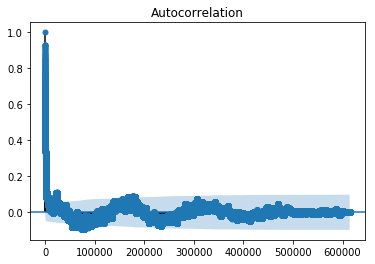

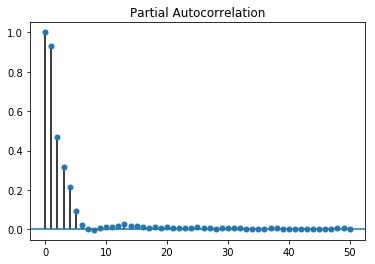

In [43]:
# Autocorrelation stuff
plot_acf(main_df['P_avg'])
plot_pacf(main_df['P_avg'],lags = 50)
plt.show()

C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                26838
Model:                 ARIMA(5, 1, 0)   Log Likelihood               40853.526
Method:                       css-mle   S.D. of innovations              0.053
Date:                Fri, 26 Jul 2019   AIC                         -81693.051
Time:                        06:31:25   BIC                         -81635.668
Sample:                             1   HQIC                        -81674.541
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.311e-07      0.000      0.002      0.998      -0.000       0.000
ar.L1.D.y     -0.1416      0.006    -23.214      0.000      -0.154      -0.130
ar.L2.D.y     -0.1345      0.006    -21.886      0.0

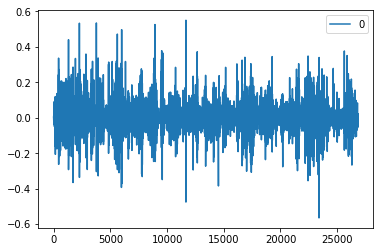

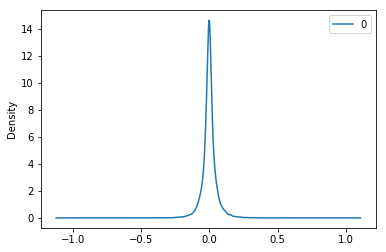

                  0
count  2.683800e+04
mean   7.407250e-08
std    5.280506e-02
min   -5.648637e-01
25%   -2.042794e-02
50%   -1.117154e-03
75%    1.858414e-02
max    5.504123e-01


In [112]:
model = ARIMA(Scaled_P_avg_R80790_Test, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
C:\Users\jamie\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an arra

Test MAE: 80.649


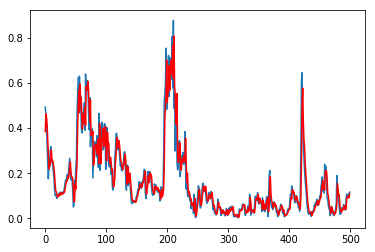

114.03710651397705


In [111]:
start = time.time()
X = Scaled_P_avg_R80790_Test[0:2000]
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
error = np.asarray(mean_absolute_error(test, predictions))
error = error.reshape((1,1))
print('Test MAE: %.3f' % P_scaler.inverse_transform(error))
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()
end = time.time()
print(end - start)

(1495, 5, 1) (1495, 1)
(495, 5, 1) (495, 1)
[[78.2552079]]


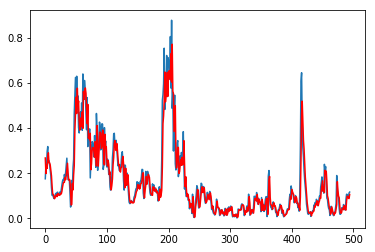

36.025208711624146
Done


In [100]:
start = time.time()
# univariate data preparation
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = Scaled_P_avg_R80790_Test[0:1500]
raw_seq_Test = Scaled_P_avg_R80790_Test[1500:2000]
# choose a number of time steps
n_steps = 5
# split into samples
X_ARIMA_Comp, y_ARIMA_Comp = split_sequence(raw_seq, n_steps)
X_ARIMA_Comp_Test, y_ARIMA_Comp_Test = split_sequence(raw_seq_Test, n_steps)
# summarize the data
n_features = 1
X_ARIMA_Comp = X_ARIMA_Comp.reshape((X_ARIMA_Comp.shape[0], X_ARIMA_Comp.shape[1], n_features))
X_ARIMA_Comp_Test= X_ARIMA_Comp_Test.reshape((X_ARIMA_Comp_Test.shape[0], X_ARIMA_Comp_Test.shape[1], n_features))
print(X_ARIMA_Comp.shape, y_ARIMA_Comp.shape)
print(X_ARIMA_Comp_Test.shape, y_ARIMA_Comp_Test.shape)

# define model
model = Sequential()
model.add(CuDNNLSTM(64, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
history = model.fit(X_ARIMA_Comp, y_ARIMA_Comp, epochs=200,verbose =0)
# Final unscaled loss function kinda iffy atm
Loss_ARIMA_Comp = np.asarray(history.history['loss'])
Loss_ARIMA_Comp = Loss_ARIMA_Comp[199].reshape((1,1))
P_scaler.inverse_transform(Loss_ARIMA_Comp)
# demonstrate prediction
ypred = [None]*len(X_ARIMA_Comp_Test)


for i in range(len(X_ARIMA_Comp_Test)):
        X_input = np.asarray(X_ARIMA_Comp_Test[i])
        X_input = X_input.reshape((1, n_steps, n_features))
        yhat = model.predict(X_input, verbose=0)
        ypred[i] = yhat

ypred_ARIMA_Comp_Test  = np.asarray(ypred)
ypred_ARIMA_Comp_Test  = ypred_ARIMA_Comp_Test.reshape((len(ypred), 1))
y_ARIMA_Comp_Test = np.asarray(y_ARIMA_Comp_Test)
y_ARIMA_Comp_Test = y_ARIMA_Comp_Test.reshape((len(y_ARIMA_Comp_Test), 1))

Mean_Abs_Error = sum(abs(ypred_ARIMA_Comp_Test - y_ARIMA_Comp_Test))/len(y_ARIMA_Comp_Test)
Mean_Abs_Error = Mean_Abs_Error.reshape((len(Mean_Abs_Error),1))
print(P_scaler.inverse_transform(Mean_Abs_Error))

plt.plot(y_ARIMA_Comp_Test)
plt.plot(ypred_ARIMA_Comp_Test, color='red')
plt.show()
end = time.time()
print(end - start)
print('Done')

In [43]:
# multivariate data preparation
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = Scaled_Wa_avg_R80711
in_seq2 = Scaled_Wa_min_R80711
in_seq3 = Scaled_Wa_max_R80711
in_seq4 = Scaled_Ws1_avg_R80711
in_seq5 = Scaled_Ws1_min_R80711
in_seq6 = Scaled_Ws1_max_R80711
in_seq7 = Scaled_Ws2_avg_R80711
in_seq8 = Scaled_Ws2_min_R80711
in_seq9 = Scaled_Ws2_max_R80711
in_seq10 = Scaled_Ws_avg_R80711
in_seq11 = Scaled_Ws_min_R80711
in_seq12 = Scaled_Ws_max_R80711
in_seq13 = Scaled_Rs_avg_R80711
in_seq14 = Scaled_Rs_min_R80711
in_seq15 = Scaled_Rs_max_R80711
out_seq = Scaled_P_avg_R80711

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
in_seq3 = in_seq3.reshape((len(in_seq3), 1))
in_seq4 = in_seq4.reshape((len(in_seq4), 1))
in_seq5 = in_seq5.reshape((len(in_seq5), 1))
in_seq6 = in_seq6.reshape((len(in_seq6), 1))
in_seq7 = in_seq7.reshape((len(in_seq7), 1))
in_seq8 = in_seq8.reshape((len(in_seq8), 1))
in_seq9 = in_seq9.reshape((len(in_seq9), 1))
in_seq10 = in_seq10.reshape((len(in_seq10), 1))
in_seq11 = in_seq11.reshape((len(in_seq11), 1))
in_seq12 = in_seq12.reshape((len(in_seq12), 1))
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq14 = in_seq14.reshape((len(in_seq14), 1))
in_seq15 = in_seq15.reshape((len(in_seq15), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4, in_seq5, in_seq6, in_seq7, in_seq8, in_seq9, in_seq10, 
                  in_seq11, in_seq12, in_seq13, in_seq14, in_seq15, out_seq))
# choose a number of time steps
n_steps_in = 144
n_steps_out = 24
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)
n_features = X.shape[2]

(132042, 144, 15) (132042, 24)


In [44]:
# Test data sorted for model

# define input sequence
in_seq1_Test = Scaled_Wa_avg_R80711_Test
in_seq2_Test = Scaled_Wa_min_R80711_Test
in_seq3_Test = Scaled_Wa_max_R80711_Test
in_seq4_Test = Scaled_Ws1_avg_R80711_Test
in_seq5_Test = Scaled_Ws1_min_R80711_Test
in_seq6_Test = Scaled_Ws1_max_R80711_Test
in_seq7_Test = Scaled_Ws2_avg_R80711_Test
in_seq8_Test = Scaled_Ws2_min_R80711_Test
in_seq9_Test = Scaled_Ws2_max_R80711_Test
in_seq10_Test = Scaled_Ws_avg_R80711_Test
in_seq11_Test = Scaled_Ws_min_R80711_Test
in_seq12_Test = Scaled_Ws_max_R80711_Test
in_seq13_Test = Scaled_Rs_avg_R80711_Test
in_seq14_Test = Scaled_Rs_min_R80711_Test
in_seq15_Test = Scaled_Rs_max_R80711_Test
out_seq_Test = Scaled_P_avg_R80711_Test

# convert to [rows, columns] structure
in_seq1_Test = in_seq1_Test.reshape((len(in_seq1_Test), 1))
in_seq2_Test = in_seq2_Test.reshape((len(in_seq2_Test), 1))
in_seq3_Test = in_seq3_Test.reshape((len(in_seq3_Test), 1))
in_seq4_Test = in_seq4_Test.reshape((len(in_seq4_Test), 1))
in_seq5_Test = in_seq5_Test.reshape((len(in_seq5_Test), 1))
in_seq6_Test = in_seq6_Test.reshape((len(in_seq6_Test), 1))
in_seq7_Test = in_seq7_Test.reshape((len(in_seq7_Test), 1))
in_seq8_Test = in_seq8_Test.reshape((len(in_seq8_Test), 1))
in_seq9_Test = in_seq9_Test.reshape((len(in_seq9_Test), 1))
in_seq10_Test = in_seq10_Test.reshape((len(in_seq10_Test), 1))
in_seq11_Test = in_seq11_Test.reshape((len(in_seq11_Test), 1))
in_seq12_Test = in_seq12_Test.reshape((len(in_seq12_Test), 1))
in_seq13_Test = in_seq13_Test.reshape((len(in_seq13_Test), 1))
in_seq14_Test = in_seq14_Test.reshape((len(in_seq14_Test), 1))
in_seq15_Test = in_seq15_Test.reshape((len(in_seq15_Test), 1))
out_seq_Test = out_seq_Test.reshape((len(out_seq_Test), 1))
# horizontally stack columns
dataset_Test = hstack((in_seq1_Test, in_seq2_Test, in_seq3_Test, in_seq4_Test, in_seq5_Test, in_seq6_Test, in_seq7_Test,
                  in_seq8_Test, in_seq9_Test, in_seq10_Test, in_seq11_Test, in_seq12_Test, in_seq13_Test, in_seq14_Test,
                  in_seq15_Test, out_seq_Test))

X_Test, y_Test = split_sequences(dataset_Test, n_steps_in, n_steps_out)
print(X_Test.shape, y_Test.shape)

(32886, 144, 15) (32886, 24)


In [45]:
# define model
model = Sequential()
model.add(CuDNNLSTM(1024, input_shape=(n_steps_in, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(24,activation = 'linear'))

opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer=opt, loss='mae', metrics = ['mae','mse'])

In [47]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # Train model
history = model.fit(
    X, y,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[tensorboard])

Train on 105633 samples, validate on 26409 samples
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[32,144,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_8/Adam/gradients/zeros_10}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node ConstantFoldingCtrl/loss_4/dense_14_loss/broadcast_weights/assert_broadcastable/AssertGuard/Switch_0}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
model.summary()

In [ ]:
    # demonstrate prediction
ypred = [None]*len(X_Test)

for i in range(len(X_Test)):
        X_input = X_Test[i]
        X_input = X_input.reshape((1, n_steps_in, n_features))
        yhat = model.predict(X_input, verbose=0)
        ypred[i] = yhat

In [ ]:
ypred  = np.asarray(ypred)
ypred  = ypred.reshape((len(ypred)*24, 1))
y_Test = np.asarray(y_Test)
y_Test = y_Test.reshape((len(y_Test)*24, 1))

Mean_Abs_Error = sum(abs(ypred - y_Test))/len(y_Test)
Mean_Abs_Error = Mean_Abs_Error.reshape((len(Mean_Abs_Error),1))
P_scaler.inverse_transform(Mean_Abs_Error)

In [ ]:
plt.plot(y_Test[0:120000:24])
plt.plot(ypred[0:120000:24], color='red')
plt.show()

In [51]:
157.59399137/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. 750s per epoch

29.115999269633523

In [101]:
28.44207403/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. from 10 min ahead

5.2547651054796845

In [ ]:
23.61839659/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. no added time +1 dense layer
                                      # 128 size 362s per epoch

In [12]:
# R80711
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1_R80711 = Scaled_Wa_avg_R80711
in_seq2_R80711 = Scaled_Wa_min_R80711
in_seq3_R80711 = Scaled_Wa_max_R80711
in_seq4_R80711 = Scaled_Ws1_avg_R80711
in_seq5_R80711 = Scaled_Ws1_min_R80711
in_seq6_R80711 = Scaled_Ws1_max_R80711
in_seq7_R80711 = Scaled_Ws2_avg_R80711
in_seq8_R80711 = Scaled_Ws2_min_R80711
in_seq9_R80711 = Scaled_Ws2_max_R80711
in_seq10_R80711 = Scaled_Ws_avg_R80711
in_seq11_R80711 = Scaled_Ws_min_R80711
in_seq12_R80711 = Scaled_Ws_max_R80711
in_seq13_R80711 = Scaled_Rs_avg_R80711
in_seq14_R80711 = Scaled_Rs_min_R80711
in_seq15_R80711 = Scaled_Rs_max_R80711
out_seq_R80711 = Scaled_P_avg_R80711
# convert to [rows, columns] structure
in_seq1_R80711 = in_seq1_R80711.reshape((len(in_seq1_R80711), 1))
in_seq2_R80711 = in_seq2_R80711.reshape((len(in_seq2_R80711), 1))
in_seq3_R80711 = in_seq3_R80711.reshape((len(in_seq3_R80711), 1))
in_seq4_R80711 = in_seq4_R80711.reshape((len(in_seq4_R80711), 1))
in_seq5_R80711 = in_seq5_R80711.reshape((len(in_seq5_R80711), 1))
in_seq6_R80711 = in_seq6_R80711.reshape((len(in_seq6_R80711), 1))
in_seq7_R80711 = in_seq7_R80711.reshape((len(in_seq7_R80711), 1))
in_seq8_R80711 = in_seq8_R80711.reshape((len(in_seq8_R80711), 1))
in_seq9_R80711 = in_seq9_R80711.reshape((len(in_seq9_R80711), 1))
in_seq10_R80711= in_seq10_R80711.reshape((len(in_seq10_R80711), 1))
in_seq11_R80711= in_seq11_R80711.reshape((len(in_seq11_R80711), 1))
in_seq12_R80711= in_seq12_R80711.reshape((len(in_seq12_R80711), 1))
in_seq13_R80711= in_seq13_R80711.reshape((len(in_seq13_R80711), 1))
in_seq14_R80711= in_seq14_R80711.reshape((len(in_seq14_R80711), 1))
in_seq15_R80711= in_seq15_R80711.reshape((len(in_seq15_R80711), 1))
out_seq_R80711 = out_seq_R80711.reshape((len(out_seq_R80711), 1))
# horizontally stack columns
dataset_R80711 = hstack((in_seq1_R80711, in_seq2_R80711, in_seq3_R80711, in_seq4_R80711, in_seq5_R80711, in_seq6_R80711, in_seq7_R80711, in_seq8_R80711, in_seq9_R80711, in_seq10_R80711, 
                  in_seq11_R80711, in_seq12_R80711, in_seq13_R80711, in_seq14_R80711, in_seq15_R80711, out_seq_R80711))
# choose a number of time steps
n_steps = 60
# convert into input/output
X_R80711, y_R80711 = split_sequences(dataset_R80711, n_steps)
print(X_R80711.shape, y_R80711.shape)
n_features = X_R80711.shape[2]



(132149, 60, 15) (132149,)


In [14]:
# Test data sorted for model

# define input sequence
in_seq1_Test_R80711 = Scaled_Wa_avg_R80711_Test
in_seq2_Test_R80711 = Scaled_Wa_min_R80711_Test
in_seq3_Test_R80711 = Scaled_Wa_max_R80711_Test
in_seq4_Test_R80711 = Scaled_Ws1_avg_R80711_Test
in_seq5_Test_R80711 = Scaled_Ws1_min_R80711_Test
in_seq6_Test_R80711 = Scaled_Ws1_max_R80711_Test
in_seq7_Test_R80711 = Scaled_Ws2_avg_R80711_Test
in_seq8_Test_R80711 = Scaled_Ws2_min_R80711_Test
in_seq9_Test_R80711 = Scaled_Ws2_max_R80711_Test
in_seq10_Test_R80711 = Scaled_Ws_avg_R80711_Test
in_seq11_Test_R80711 = Scaled_Ws_min_R80711_Test
in_seq12_Test_R80711 = Scaled_Ws_max_R80711_Test
in_seq13_Test_R80711 = Scaled_Rs_avg_R80711_Test
in_seq14_Test_R80711 = Scaled_Rs_min_R80711_Test
in_seq15_Test_R80711 = Scaled_Rs_max_R80711_Test
out_seq_Test_R80711 = Scaled_P_avg_R80711_Test

# convert to [rows, columns] structure
in_seq1_Test_R80711 = in_seq1_Test_R80711.reshape((len(in_seq1_Test_R80711), 1))
in_seq2_Test_R80711 = in_seq2_Test_R80711.reshape((len(in_seq2_Test_R80711), 1))
in_seq3_Test_R80711 = in_seq3_Test_R80711.reshape((len(in_seq3_Test_R80711), 1))
in_seq4_Test_R80711 = in_seq4_Test_R80711.reshape((len(in_seq4_Test_R80711), 1))
in_seq5_Test_R80711 = in_seq5_Test_R80711.reshape((len(in_seq5_Test_R80711), 1))
in_seq6_Test_R80711 = in_seq6_Test_R80711.reshape((len(in_seq6_Test_R80711), 1))
in_seq7_Test_R80711 = in_seq7_Test_R80711.reshape((len(in_seq7_Test_R80711), 1))
in_seq8_Test_R80711 = in_seq8_Test_R80711.reshape((len(in_seq8_Test_R80711), 1))
in_seq9_Test_R80711 = in_seq9_Test_R80711.reshape((len(in_seq9_Test_R80711), 1))
in_seq10_Test_R80711 = in_seq10_Test_R80711.reshape((len(in_seq10_Test_R80711), 1))
in_seq11_Test_R80711 = in_seq11_Test_R80711.reshape((len(in_seq11_Test_R80711), 1))
in_seq12_Test_R80711 = in_seq12_Test_R80711.reshape((len(in_seq12_Test_R80711), 1))
in_seq13_Test_R80711 = in_seq13_Test_R80711.reshape((len(in_seq13_Test_R80711), 1))
in_seq14_Test_R80711 = in_seq14_Test_R80711.reshape((len(in_seq14_Test_R80711), 1))
in_seq15_Test_R80711 = in_seq15_Test_R80711.reshape((len(in_seq15_Test_R80711), 1))
out_seq_Test_R80711 = out_seq_Test_R80711.reshape((len(out_seq_Test_R80711), 1))
# horizontally stack columns
dataset_Test_R80711 = hstack((in_seq1_Test_R80711, in_seq2_Test_R80711, in_seq3_Test_R80711, in_seq4_Test_R80711, in_seq5_Test_R80711,
                              in_seq6_Test_R80711, in_seq7_Test_R80711, in_seq8_Test_R80711, in_seq9_Test_R80711, in_seq10_Test_R80711,
                              in_seq11_Test_R80711, in_seq12_Test_R80711, in_seq13_Test_R80711, in_seq14_Test_R80711, in_seq15_Test_R80711, 
                              out_seq_Test_R80711))

X_Test_R80711, y_Test_R80711 = split_sequences(dataset_Test_R80711, n_steps)
print(X_Test_R80711.shape, y_Test_R80711.shape)


(32993, 60, 15) (32993,)


In [15]:
# define model
model = Sequential()
model.add(CuDNNLSTM(1024, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'linear'))

opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer=opt, loss='mae', metrics = ['mae','mse'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # Train model
history = model.fit(
    X_R80711, y_R80711,
    validation_split=0.2, # 64% Train 16% validation 20% Test
    epochs=EPOCHS,
    callbacks=[tensorboard])

Train on 105719 samples, validate on 26430 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
105719/105719 [==============================] - 392s 4ms/sample - loss: 0.0682 - mean_absolute_error: 0.0682 - mean_squared_error: 0.0142 - val_loss: 0.0338 - val_mean_absolute_error: 0.0338 - val_mean_squared_error: 0.0029
Epoch 2/10
105719/105719 [==============================] - 389s 4ms/sample - loss: 0.0466 - mean_absolute_error: 0.0466 - mean_squared_error: 0.0054 - val_loss: 0.1617 - val_mean_absolute_error: 0.1617 - val_mean_squared_error: 0.0371
Epoch 3/10
105719/105719 [==============================] - 388s 4ms/sample - loss: 0.0372 - mean_absolute_error: 0.0372 - mean_squared_error: 0.0035 - val_loss: 0.0251 - val_mean_absolute_error: 0.0251 - val_mean_squared_error: 0.0012
Epoch 4/10
105719/105719 [==============================] - 389s 4ms/sample - loss: 0.0311 - mean_absolute_error: 0.0311 - mean_squared_error: 0.0025 - val_loss: 0.0217 - val_mean_absolute_erro

In [18]:
    # demonstrate prediction
ypred_R80711 = [None]*len(X_Test_R80711)

for i in range(len(X_Test_R80711)):
        X_input_R80711 = X_Test_R80711[i]
        X_input_R80711 = X_input_R80711.reshape((1, n_steps, n_features))
        yhat_R80711 = model.predict(X_input_R80711, verbose=0)
        ypred_R80711[i] = yhat_R80711

In [19]:
ypred_R80711  = np.asarray(ypred_R80711)
ypred_R80711  = ypred_R80711.reshape((len(ypred_R80711), 1))
y_Test_R80711 = np.asarray(y_Test_R80711)
y_Test_R80711 = y_Test_R80711.reshape((len(y_Test_R80711), 1))

Mean_Abs_Error_R80711 = sum(abs(ypred_R80711 - y_Test_R80711))/len(y_Test_R80711)
Mean_Abs_Error_R80711 = Mean_Abs_Error_R80711.reshape((len(Mean_Abs_Error_R80711),1))
P_scaler.inverse_transform(Mean_Abs_Error_R80711)


array([[29.20375242]])

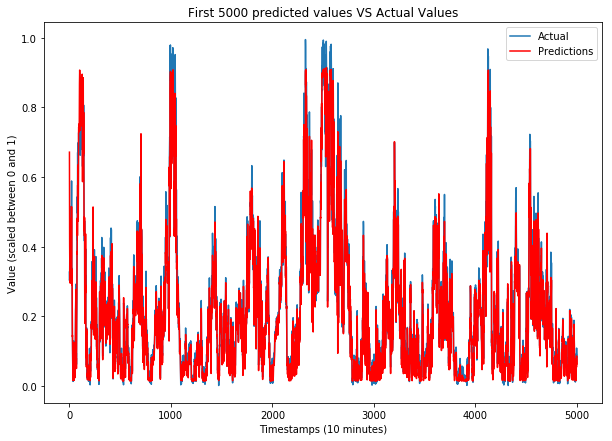

In [57]:
plt.figure(figsize = (10,7))
plt.plot(y_Test_R80711[0:5000], label = 'Actual')
plt.plot(ypred_R80711[0:5000], color='red', label = 'Predictions')
plt.title('First 5000 predicted values VS Actual Values')
plt.legend(loc='best')
plt.xlabel('Timestamps (10 minutes)')
plt.ylabel('Value (scaled between 0 and 1)')
plt.show()

In [21]:
# R80721
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1_R80721 = Scaled_Wa_avg_R80721
in_seq2_R80721 = Scaled_Wa_min_R80721
in_seq3_R80721 = Scaled_Wa_max_R80721
in_seq4_R80721 = Scaled_Ws1_avg_R80721
in_seq5_R80721 = Scaled_Ws1_min_R80721
in_seq6_R80721 = Scaled_Ws1_max_R80721
in_seq7_R80721 = Scaled_Ws2_avg_R80721
in_seq8_R80721 = Scaled_Ws2_min_R80721
in_seq9_R80721 = Scaled_Ws2_max_R80721
in_seq10_R80721 = Scaled_Ws_avg_R80721
in_seq11_R80721 = Scaled_Ws_min_R80721
in_seq12_R80721 = Scaled_Ws_max_R80721
in_seq13_R80721 = Scaled_Rs_avg_R80721
in_seq14_R80721 = Scaled_Rs_min_R80721
in_seq15_R80721 = Scaled_Rs_max_R80721
out_seq_R80721 = Scaled_P_avg_R80721
# convert to [rows, columns] structure
in_seq1_R80721 = in_seq1_R80721.reshape((len(in_seq1_R80721), 1))
in_seq2_R80721 = in_seq2_R80721.reshape((len(in_seq2_R80721), 1))
in_seq3_R80721 = in_seq3_R80721.reshape((len(in_seq3_R80721), 1))
in_seq4_R80721 = in_seq4_R80721.reshape((len(in_seq4_R80721), 1))
in_seq5_R80721 = in_seq5_R80721.reshape((len(in_seq5_R80721), 1))
in_seq6_R80721 = in_seq6_R80721.reshape((len(in_seq6_R80721), 1))
in_seq7_R80721 = in_seq7_R80721.reshape((len(in_seq7_R80721), 1))
in_seq8_R80721 = in_seq8_R80721.reshape((len(in_seq8_R80721), 1))
in_seq9_R80721 = in_seq9_R80721.reshape((len(in_seq9_R80721), 1))
in_seq10_R80721= in_seq10_R80721.reshape((len(in_seq10_R80721), 1))
in_seq11_R80721= in_seq11_R80721.reshape((len(in_seq11_R80721), 1))
in_seq12_R80721= in_seq12_R80721.reshape((len(in_seq12_R80721), 1))
in_seq13_R80721= in_seq13_R80721.reshape((len(in_seq13_R80721), 1))
in_seq14_R80721= in_seq14_R80721.reshape((len(in_seq14_R80721), 1))
in_seq15_R80721= in_seq15_R80721.reshape((len(in_seq15_R80721), 1))
out_seq_R80721 = out_seq_R80721.reshape((len(out_seq_R80721), 1))
# horizontally stack columns
dataset_R80721 = hstack((in_seq1_R80721, in_seq2_R80721, in_seq3_R80721, in_seq4_R80721, in_seq5_R80721, in_seq6_R80721, in_seq7_R80721, in_seq8_R80721, in_seq9_R80721, in_seq10_R80721, 
                  in_seq11_R80721, in_seq12_R80721, in_seq13_R80721, in_seq14_R80721, in_seq15_R80721, out_seq_R80721))
# choose a number of time steps
n_steps = 60
# convert into input/output
X_R80721, y_R80721 = split_sequences(dataset_R80721, n_steps)
print(X_R80721.shape, y_R80721.shape)
n_features = X_R80721.shape[2]

(125589, 60, 15) (125589,)


In [22]:
# Test data sorted for model

# define input sequence
in_seq1_Test_R80721 = Scaled_Wa_avg_R80721_Test
in_seq2_Test_R80721 = Scaled_Wa_min_R80721_Test
in_seq3_Test_R80721 = Scaled_Wa_max_R80721_Test
in_seq4_Test_R80721 = Scaled_Ws1_avg_R80721_Test
in_seq5_Test_R80721 = Scaled_Ws1_min_R80721_Test
in_seq6_Test_R80721 = Scaled_Ws1_max_R80721_Test
in_seq7_Test_R80721 = Scaled_Ws2_avg_R80721_Test
in_seq8_Test_R80721 = Scaled_Ws2_min_R80721_Test
in_seq9_Test_R80721 = Scaled_Ws2_max_R80721_Test
in_seq10_Test_R80721 = Scaled_Ws_avg_R80721_Test
in_seq11_Test_R80721 = Scaled_Ws_min_R80721_Test
in_seq12_Test_R80721 = Scaled_Ws_max_R80721_Test
in_seq13_Test_R80721 = Scaled_Rs_avg_R80721_Test
in_seq14_Test_R80721 = Scaled_Rs_min_R80721_Test
in_seq15_Test_R80721 = Scaled_Rs_max_R80721_Test
out_seq_Test_R80721 = Scaled_P_avg_R80721_Test

# convert to [rows, columns] structure
in_seq1_Test_R80721 = in_seq1_Test_R80721.reshape((len(in_seq1_Test_R80721), 1))
in_seq2_Test_R80721 = in_seq2_Test_R80721.reshape((len(in_seq2_Test_R80721), 1))
in_seq3_Test_R80721 = in_seq3_Test_R80721.reshape((len(in_seq3_Test_R80721), 1))
in_seq4_Test_R80721 = in_seq4_Test_R80721.reshape((len(in_seq4_Test_R80721), 1))
in_seq5_Test_R80721 = in_seq5_Test_R80721.reshape((len(in_seq5_Test_R80721), 1))
in_seq6_Test_R80721 = in_seq6_Test_R80721.reshape((len(in_seq6_Test_R80721), 1))
in_seq7_Test_R80721 = in_seq7_Test_R80721.reshape((len(in_seq7_Test_R80721), 1))
in_seq8_Test_R80721 = in_seq8_Test_R80721.reshape((len(in_seq8_Test_R80721), 1))
in_seq9_Test_R80721 = in_seq9_Test_R80721.reshape((len(in_seq9_Test_R80721), 1))
in_seq10_Test_R80721 = in_seq10_Test_R80721.reshape((len(in_seq10_Test_R80721), 1))
in_seq11_Test_R80721 = in_seq11_Test_R80721.reshape((len(in_seq11_Test_R80721), 1))
in_seq12_Test_R80721 = in_seq12_Test_R80721.reshape((len(in_seq12_Test_R80721), 1))
in_seq13_Test_R80721 = in_seq13_Test_R80721.reshape((len(in_seq13_Test_R80721), 1))
in_seq14_Test_R80721 = in_seq14_Test_R80721.reshape((len(in_seq14_Test_R80721), 1))
in_seq15_Test_R80721 = in_seq15_Test_R80721.reshape((len(in_seq15_Test_R80721), 1))
out_seq_Test_R80721 = out_seq_Test_R80721.reshape((len(out_seq_Test_R80721), 1))
# horizontally stack columns
dataset_Test_R80721 = hstack((in_seq1_Test_R80721, in_seq2_Test_R80721, in_seq3_Test_R80721, in_seq4_Test_R80721, in_seq5_Test_R80721,
                              in_seq6_Test_R80721, in_seq7_Test_R80721, in_seq8_Test_R80721, in_seq9_Test_R80721, in_seq10_Test_R80721,
                              in_seq11_Test_R80721, in_seq12_Test_R80721, in_seq13_Test_R80721, in_seq14_Test_R80721, in_seq15_Test_R80721, 
                              out_seq_Test_R80721))

X_Test_R80721, y_Test_R80721 = split_sequences(dataset_Test_R80721, n_steps)
print(X_Test_R80721.shape, y_Test_R80721.shape)

(31353, 60, 15) (31353,)


In [23]:
# define model
model = Sequential()
model.add(CuDNNLSTM(1024, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'linear'))

opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer=opt, loss='mae', metrics = ['mae','mse'])

In [24]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # Train model
history = model.fit(
    X_R80721, y_R80721,
    validation_split=0.2, # 64% Train 16% validation 20% Test
    epochs=EPOCHS,
    callbacks=[tensorboard])

Train on 100471 samples, validate on 25118 samples
Epoch 1/10
100471/100471 [==============================] - 370s 4ms/sample - loss: 0.0633 - mean_absolute_error: 0.0633 - mean_squared_error: 0.0139 - val_loss: 0.0886 - val_mean_absolute_error: 0.0886 - val_mean_squared_error: 0.0149
Epoch 2/10
100471/100471 [==============================] - 369s 4ms/sample - loss: 0.0446 - mean_absolute_error: 0.0446 - mean_squared_error: 0.0053 - val_loss: 0.0937 - val_mean_absolute_error: 0.0937 - val_mean_squared_error: 0.0103
Epoch 3/10
100471/100471 [==============================] - 370s 4ms/sample - loss: 0.0434 - mean_absolute_error: 0.0434 - mean_squared_error: 0.0049 - val_loss: 0.0792 - val_mean_absolute_error: 0.0792 - val_mean_squared_error: 0.0095
Epoch 4/10
100471/100471 [==============================] - 369s 4ms/sample - loss: 0.0384 - mean_absolute_error: 0.0384 - mean_squared_error: 0.0039 - val_loss: 0.0298 - val_mean_absolute_error: 0.0298 - val_mean_squared_error: 0.0015
Epoch

In [25]:
    # demonstrate prediction
ypred_R80721 = [None]*len(X_Test_R80721)

for i in range(len(X_Test_R80721)):
        X_input_R80721 = X_Test_R80721[i]
        X_input_R80721 = X_input_R80721.reshape((1, n_steps, n_features))
        yhat_R80721 = model.predict(X_input_R80721, verbose=0)
        ypred_R80721[i] = yhat_R80721

In [26]:
ypred_R80721  = np.asarray(ypred_R80721)
ypred_R80721  = ypred_R80721.reshape((len(ypred_R80721), 1))
y_Test_R80721 = np.asarray(y_Test_R80721)
y_Test_R80721 = y_Test_R80721.reshape((len(y_Test_R80721), 1))

Mean_Abs_Error_R80721 = sum(abs(ypred_R80721 - y_Test_R80721))/len(y_Test_R80721)
Mean_Abs_Error_R80721 = Mean_Abs_Error_R80721.reshape((len(Mean_Abs_Error_R80721),1))
P_scaler.inverse_transform(Mean_Abs_Error_R80721)

array([[35.42722957]])

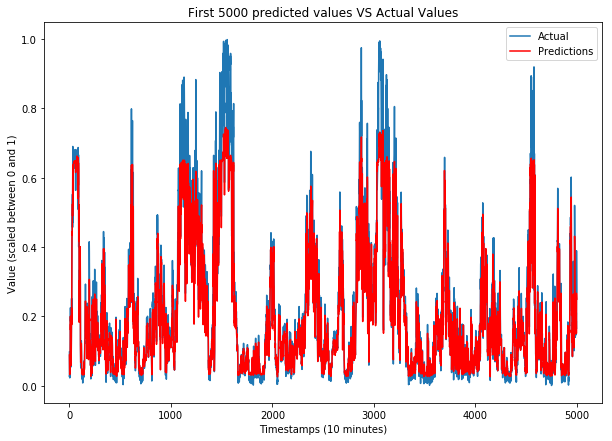

In [58]:
plt.figure(figsize = (10,7))
plt.plot(y_Test_R80721[0:5000], label = 'Actual')
plt.plot(ypred_R80721[0:5000], color='red', label = 'Predictions')
plt.title('First 5000 predicted values VS Actual Values')
plt.legend(loc='best')
plt.xlabel('Timestamps (10 minutes)')
plt.ylabel('Value (scaled between 0 and 1)')
plt.show()

In [26]:
22.48803149/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data.

4.154736501984287

In [ ]:
32.6936508/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. no added time +1 dense layer
                                      # 128 size worse off :/    

In [ ]:
21.25304121/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. 372s per epoch

In [28]:
# R80736
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1_R80736 = Scaled_Wa_avg_R80736
in_seq2_R80736 = Scaled_Wa_min_R80736
in_seq3_R80736 = Scaled_Wa_max_R80736
in_seq4_R80736 = Scaled_Ws1_avg_R80736
in_seq5_R80736 = Scaled_Ws1_min_R80736
in_seq6_R80736 = Scaled_Ws1_max_R80736
in_seq7_R80736 = Scaled_Ws2_avg_R80736
in_seq8_R80736 = Scaled_Ws2_min_R80736
in_seq9_R80736 = Scaled_Ws2_max_R80736
in_seq10_R80736 = Scaled_Ws_avg_R80736
in_seq11_R80736 = Scaled_Ws_min_R80736
in_seq12_R80736 = Scaled_Ws_max_R80736
in_seq13_R80736 = Scaled_Rs_avg_R80736
in_seq14_R80736 = Scaled_Rs_min_R80736
in_seq15_R80736 = Scaled_Rs_max_R80736
out_seq_R80736 = Scaled_P_avg_R80736
# convert to [rows, columns] structure
in_seq1_R80736 = in_seq1_R80736.reshape((len(in_seq1_R80736), 1))
in_seq2_R80736 = in_seq2_R80736.reshape((len(in_seq2_R80736), 1))
in_seq3_R80736 = in_seq3_R80736.reshape((len(in_seq3_R80736), 1))
in_seq4_R80736 = in_seq4_R80736.reshape((len(in_seq4_R80736), 1))
in_seq5_R80736 = in_seq5_R80736.reshape((len(in_seq5_R80736), 1))
in_seq6_R80736 = in_seq6_R80736.reshape((len(in_seq6_R80736), 1))
in_seq7_R80736 = in_seq7_R80736.reshape((len(in_seq7_R80736), 1))
in_seq8_R80736 = in_seq8_R80736.reshape((len(in_seq8_R80736), 1))
in_seq9_R80736 = in_seq9_R80736.reshape((len(in_seq9_R80736), 1))
in_seq10_R80736= in_seq10_R80736.reshape((len(in_seq10_R80736), 1))
in_seq11_R80736= in_seq11_R80736.reshape((len(in_seq11_R80736), 1))
in_seq12_R80736= in_seq12_R80736.reshape((len(in_seq12_R80736), 1))
in_seq13_R80736= in_seq13_R80736.reshape((len(in_seq13_R80736), 1))
in_seq14_R80736= in_seq14_R80736.reshape((len(in_seq14_R80736), 1))
in_seq15_R80736= in_seq15_R80736.reshape((len(in_seq15_R80736), 1))
out_seq_R80736 = out_seq_R80736.reshape((len(out_seq_R80736), 1))
# horizontally stack columns
dataset_R80736 = hstack((in_seq1_R80736, in_seq2_R80736, in_seq3_R80736, in_seq4_R80736, in_seq5_R80736, in_seq6_R80736, in_seq7_R80736, in_seq8_R80736, in_seq9_R80736, in_seq10_R80736, 
                  in_seq11_R80736, in_seq12_R80736, in_seq13_R80736, in_seq14_R80736, in_seq15_R80736, out_seq_R80736))
# choose a number of time steps
n_steps = 60
# convert into input/output
X_R80736, y_R80736 = split_sequences(dataset_R80736, n_steps)
print(X_R80736.shape, y_R80736.shape)
n_features = X_R80736.shape[2]

(126185, 60, 15) (126185,)


In [29]:
# Test data sorted for model

# define input sequence
in_seq1_Test_R80736 = Scaled_Wa_avg_R80736_Test
in_seq2_Test_R80736 = Scaled_Wa_min_R80736_Test
in_seq3_Test_R80736 = Scaled_Wa_max_R80736_Test
in_seq4_Test_R80736 = Scaled_Ws1_avg_R80736_Test
in_seq5_Test_R80736 = Scaled_Ws1_min_R80736_Test
in_seq6_Test_R80736 = Scaled_Ws1_max_R80736_Test
in_seq7_Test_R80736 = Scaled_Ws2_avg_R80736_Test
in_seq8_Test_R80736 = Scaled_Ws2_min_R80736_Test
in_seq9_Test_R80736 = Scaled_Ws2_max_R80736_Test
in_seq10_Test_R80736 = Scaled_Ws_avg_R80736_Test
in_seq11_Test_R80736 = Scaled_Ws_min_R80736_Test
in_seq12_Test_R80736 = Scaled_Ws_max_R80736_Test
in_seq13_Test_R80736 = Scaled_Rs_avg_R80736_Test
in_seq14_Test_R80736 = Scaled_Rs_min_R80736_Test
in_seq15_Test_R80736 = Scaled_Rs_max_R80736_Test
out_seq_Test_R80736 = Scaled_P_avg_R80736_Test

# convert to [rows, columns] structure
in_seq1_Test_R80736 = in_seq1_Test_R80736.reshape((len(in_seq1_Test_R80736), 1))
in_seq2_Test_R80736 = in_seq2_Test_R80736.reshape((len(in_seq2_Test_R80736), 1))
in_seq3_Test_R80736 = in_seq3_Test_R80736.reshape((len(in_seq3_Test_R80736), 1))
in_seq4_Test_R80736 = in_seq4_Test_R80736.reshape((len(in_seq4_Test_R80736), 1))
in_seq5_Test_R80736 = in_seq5_Test_R80736.reshape((len(in_seq5_Test_R80736), 1))
in_seq6_Test_R80736 = in_seq6_Test_R80736.reshape((len(in_seq6_Test_R80736), 1))
in_seq7_Test_R80736 = in_seq7_Test_R80736.reshape((len(in_seq7_Test_R80736), 1))
in_seq8_Test_R80736 = in_seq8_Test_R80736.reshape((len(in_seq8_Test_R80736), 1))
in_seq9_Test_R80736 = in_seq9_Test_R80736.reshape((len(in_seq9_Test_R80736), 1))
in_seq10_Test_R80736 = in_seq10_Test_R80736.reshape((len(in_seq10_Test_R80736), 1))
in_seq11_Test_R80736 = in_seq11_Test_R80736.reshape((len(in_seq11_Test_R80736), 1))
in_seq12_Test_R80736 = in_seq12_Test_R80736.reshape((len(in_seq12_Test_R80736), 1))
in_seq13_Test_R80736 = in_seq13_Test_R80736.reshape((len(in_seq13_Test_R80736), 1))
in_seq14_Test_R80736 = in_seq14_Test_R80736.reshape((len(in_seq14_Test_R80736), 1))
in_seq15_Test_R80736 = in_seq15_Test_R80736.reshape((len(in_seq15_Test_R80736), 1))
out_seq_Test_R80736 = out_seq_Test_R80736.reshape((len(out_seq_Test_R80736), 1))
# horizontally stack columns
dataset_Test_R80736 = hstack((in_seq1_Test_R80736, in_seq2_Test_R80736, in_seq3_Test_R80736, in_seq4_Test_R80736, in_seq5_Test_R80736,
                              in_seq6_Test_R80736, in_seq7_Test_R80736, in_seq8_Test_R80736, in_seq9_Test_R80736, in_seq10_Test_R80736,
                              in_seq11_Test_R80736, in_seq12_Test_R80736, in_seq13_Test_R80736, in_seq14_Test_R80736, in_seq15_Test_R80736, 
                              out_seq_Test_R80736))

X_Test_R80736, y_Test_R80736 = split_sequences(dataset_Test_R80736, n_steps)
print(X_Test_R80736.shape, y_Test_R80736.shape)

(31501, 60, 15) (31501,)


In [30]:
# define model
model = Sequential()
model.add(CuDNNLSTM(1024, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'linear'))

opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer=opt, loss='mae', metrics = ['mae','mse'])

In [31]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # Train model
history = model.fit(
    X_R80736, y_R80736,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[tensorboard])

Train on 100948 samples, validate on 25237 samples
Epoch 1/10
100948/100948 [==============================] - 381s 4ms/sample - loss: 0.0664 - mean_absolute_error: 0.0664 - mean_squared_error: 0.0128 - val_loss: 0.0266 - val_mean_absolute_error: 0.0266 - val_mean_squared_error: 0.0017
Epoch 2/10
100948/100948 [==============================] - 380s 4ms/sample - loss: 0.0455 - mean_absolute_error: 0.0455 - mean_squared_error: 0.0056 - val_loss: 0.0364 - val_mean_absolute_error: 0.0364 - val_mean_squared_error: 0.0037
Epoch 3/10
100948/100948 [==============================] - 384s 4ms/sample - loss: 0.0380 - mean_absolute_error: 0.0380 - mean_squared_error: 0.0038 - val_loss: 0.0222 - val_mean_absolute_error: 0.0222 - val_mean_squared_error: 0.0011
Epoch 4/10
100948/100948 [==============================] - 384s 4ms/sample - loss: 0.0317 - mean_absolute_error: 0.0317 - mean_squared_error: 0.0026 - val_loss: 0.0280 - val_mean_absolute_error: 0.0280 - val_mean_squared_error: 0.0017
Epoch

In [32]:
    # demonstrate prediction
ypred_R80736 = [None]*len(X_Test_R80736)

for i in range(len(X_Test_R80736)):
        X_input_R80736 = X_Test_R80736[i]
        X_input_R80736 = X_input_R80736.reshape((1, n_steps, n_features))
        yhat_R80736 = model.predict(X_input_R80736, verbose=0)
        ypred_R80736[i] = yhat_R80736

In [33]:
ypred_R80736  = np.asarray(ypred_R80736)
ypred_R80736  = ypred_R80736.reshape((len(ypred_R80736), 1))
y_Test_R80736 = np.asarray(y_Test_R80736)
y_Test_R80736 = y_Test_R80736.reshape((len(y_Test_R80736), 1))

Mean_Abs_Error_R80736 = sum(abs(ypred_R80736 - y_Test_R80736))/len(y_Test_R80736)
Mean_Abs_Error_R80736 = Mean_Abs_Error_R80736.reshape((len(Mean_Abs_Error_R80736),1))
P_scaler.inverse_transform(Mean_Abs_Error_R80736)

array([[29.84788177]])

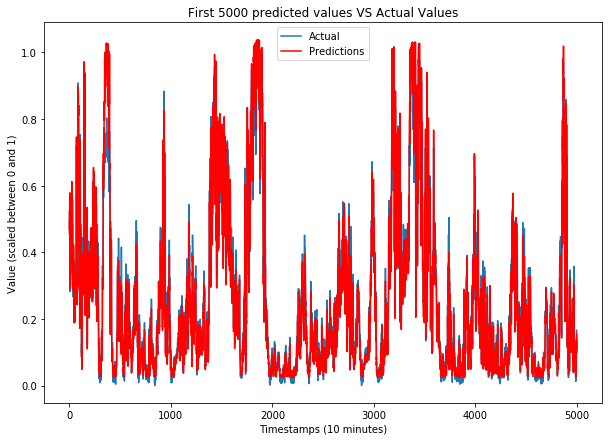

In [59]:
plt.figure(figsize = (10,7))
plt.plot(y_Test_R80736[0:5000], label = 'Actual')
plt.plot(ypred_R80736[0:5000], color='red', label = 'Predictions')
plt.title('First 5000 predicted values VS Actual Values')
plt.legend(loc='best')
plt.xlabel('Timestamps (10 minutes)')
plt.ylabel('Value (scaled between 0 and 1)')
plt.show()

In [11]:
19.85707031/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data.

3.6686579203747565

In [36]:
28.68692315/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. 
                                      # 376s per epoch additional dense layer of size 32

5.300001771783496

In [35]:
# R80790
# multivariate data preparation
from numpy import array
from numpy import hstack
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1_R80790 = Scaled_Wa_avg_R80790
in_seq2_R80790 = Scaled_Wa_min_R80790
in_seq3_R80790 = Scaled_Wa_max_R80790
in_seq4_R80790 = Scaled_Ws1_avg_R80790
in_seq5_R80790 = Scaled_Ws1_min_R80790
in_seq6_R80790 = Scaled_Ws1_max_R80790
in_seq7_R80790 = Scaled_Ws2_avg_R80790
in_seq8_R80790 = Scaled_Ws2_min_R80790
in_seq9_R80790 = Scaled_Ws2_max_R80790
in_seq10_R80790 = Scaled_Ws_avg_R80790
in_seq11_R80790 = Scaled_Ws_min_R80790
in_seq12_R80790 = Scaled_Ws_max_R80790
in_seq13_R80790 = Scaled_Rs_avg_R80790
in_seq14_R80790 = Scaled_Rs_min_R80790
in_seq15_R80790 = Scaled_Rs_max_R80790
out_seq_R80790 = Scaled_P_avg_R80790
# convert to [rows, columns] structure
in_seq1_R80790 = in_seq1_R80790.reshape((len(in_seq1_R80790), 1))
in_seq2_R80790 = in_seq2_R80790.reshape((len(in_seq2_R80790), 1))
in_seq3_R80790 = in_seq3_R80790.reshape((len(in_seq3_R80790), 1))
in_seq4_R80790 = in_seq4_R80790.reshape((len(in_seq4_R80790), 1))
in_seq5_R80790 = in_seq5_R80790.reshape((len(in_seq5_R80790), 1))
in_seq6_R80790 = in_seq6_R80790.reshape((len(in_seq6_R80790), 1))
in_seq7_R80790 = in_seq7_R80790.reshape((len(in_seq7_R80790), 1))
in_seq8_R80790 = in_seq8_R80790.reshape((len(in_seq8_R80790), 1))
in_seq9_R80790 = in_seq9_R80790.reshape((len(in_seq9_R80790), 1))
in_seq10_R80790= in_seq10_R80790.reshape((len(in_seq10_R80790), 1))
in_seq11_R80790= in_seq11_R80790.reshape((len(in_seq11_R80790), 1))
in_seq12_R80790= in_seq12_R80790.reshape((len(in_seq12_R80790), 1))
in_seq13_R80790= in_seq13_R80790.reshape((len(in_seq13_R80790), 1))
in_seq14_R80790= in_seq14_R80790.reshape((len(in_seq14_R80790), 1))
in_seq15_R80790= in_seq15_R80790.reshape((len(in_seq15_R80790), 1))
out_seq_R80790 = out_seq_R80790.reshape((len(out_seq_R80790), 1))
# horizontally stack columns
dataset_R80790 = hstack((in_seq1_R80790, in_seq2_R80790, in_seq3_R80790, in_seq4_R80790, in_seq5_R80790, in_seq6_R80790, in_seq7_R80790, in_seq8_R80790, in_seq9_R80790, in_seq10_R80790, 
                  in_seq11_R80790, in_seq12_R80790, in_seq13_R80790, in_seq14_R80790, in_seq15_R80790, out_seq_R80790))
# choose a number of time steps
n_steps = 60
# convert into input/output
X_R80790, y_R80790 = split_sequences(dataset_R80790, n_steps)
print(X_R80790.shape, y_R80790.shape)
n_features = X_R80790.shape[2]


(107299, 60, 15) (107299,)


In [36]:
# Test data sorted for model

# define input sequence
in_seq1_Test_R80790 = Scaled_Wa_avg_R80790_Test
in_seq2_Test_R80790 = Scaled_Wa_min_R80790_Test
in_seq3_Test_R80790 = Scaled_Wa_max_R80790_Test
in_seq4_Test_R80790 = Scaled_Ws1_avg_R80790_Test
in_seq5_Test_R80790 = Scaled_Ws1_min_R80790_Test
in_seq6_Test_R80790 = Scaled_Ws1_max_R80790_Test
in_seq7_Test_R80790 = Scaled_Ws2_avg_R80790_Test
in_seq8_Test_R80790 = Scaled_Ws2_min_R80790_Test
in_seq9_Test_R80790 = Scaled_Ws2_max_R80790_Test
in_seq10_Test_R80790 = Scaled_Ws_avg_R80790_Test
in_seq11_Test_R80790 = Scaled_Ws_min_R80790_Test
in_seq12_Test_R80790 = Scaled_Ws_max_R80790_Test
in_seq13_Test_R80790 = Scaled_Rs_avg_R80790_Test
in_seq14_Test_R80790 = Scaled_Rs_min_R80790_Test
in_seq15_Test_R80790 = Scaled_Rs_max_R80790_Test
out_seq_Test_R80790 = Scaled_P_avg_R80790_Test

# convert to [rows, columns] structure
in_seq1_Test_R80790 = in_seq1_Test_R80790.reshape((len(in_seq1_Test_R80790), 1))
in_seq2_Test_R80790 = in_seq2_Test_R80790.reshape((len(in_seq2_Test_R80790), 1))
in_seq3_Test_R80790 = in_seq3_Test_R80790.reshape((len(in_seq3_Test_R80790), 1))
in_seq4_Test_R80790 = in_seq4_Test_R80790.reshape((len(in_seq4_Test_R80790), 1))
in_seq5_Test_R80790 = in_seq5_Test_R80790.reshape((len(in_seq5_Test_R80790), 1))
in_seq6_Test_R80790 = in_seq6_Test_R80790.reshape((len(in_seq6_Test_R80790), 1))
in_seq7_Test_R80790 = in_seq7_Test_R80790.reshape((len(in_seq7_Test_R80790), 1))
in_seq8_Test_R80790 = in_seq8_Test_R80790.reshape((len(in_seq8_Test_R80790), 1))
in_seq9_Test_R80790 = in_seq9_Test_R80790.reshape((len(in_seq9_Test_R80790), 1))
in_seq10_Test_R80790 = in_seq10_Test_R80790.reshape((len(in_seq10_Test_R80790), 1))
in_seq11_Test_R80790 = in_seq11_Test_R80790.reshape((len(in_seq11_Test_R80790), 1))
in_seq12_Test_R80790 = in_seq12_Test_R80790.reshape((len(in_seq12_Test_R80790), 1))
in_seq13_Test_R80790 = in_seq13_Test_R80790.reshape((len(in_seq13_Test_R80790), 1))
in_seq14_Test_R80790 = in_seq14_Test_R80790.reshape((len(in_seq14_Test_R80790), 1))
in_seq15_Test_R80790 = in_seq15_Test_R80790.reshape((len(in_seq15_Test_R80790), 1))
out_seq_Test_R80790 = out_seq_Test_R80790.reshape((len(out_seq_Test_R80790), 1))
# horizontally stack columns
dataset_Test_R80790 = hstack((in_seq1_Test_R80790, in_seq2_Test_R80790, in_seq3_Test_R80790, in_seq4_Test_R80790, in_seq5_Test_R80790,
                              in_seq6_Test_R80790, in_seq7_Test_R80790, in_seq8_Test_R80790, in_seq9_Test_R80790, in_seq10_Test_R80790,
                              in_seq11_Test_R80790, in_seq12_Test_R80790, in_seq13_Test_R80790, in_seq14_Test_R80790, in_seq15_Test_R80790, 
                              out_seq_Test_R80790))

X_Test_R80790, y_Test_R80790 = split_sequences(dataset_Test_R80790, n_steps)
print(X_Test_R80790.shape, y_Test_R80790.shape)


(26780, 60, 15) (26780,)


In [38]:
# define model
model = Sequential()
model.add(CuDNNLSTM(1024, input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(CuDNNLSTM(64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation = 'linear'))

opt = tf.keras.optimizers.Adam(lr=0.001,decay=1e-6)
model.compile(optimizer=opt, loss='mae', metrics = ['mae','mse'])

In [39]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
            # Train model
history = model.fit(
    X_R80790, y_R80790,
    validation_split=0.2,
    epochs=EPOCHS,
    callbacks=[tensorboard])


Train on 85839 samples, validate on 21460 samples
Epoch 1/10
85839/85839 [==============================] - 301s 4ms/sample - loss: 0.0724 - mean_absolute_error: 0.0724 - mean_squared_error: 0.0167 - val_loss: 0.0308 - val_mean_absolute_error: 0.0308 - val_mean_squared_error: 0.0021
Epoch 2/10
85839/85839 [==============================] - 299s 3ms/sample - loss: 0.0525 - mean_absolute_error: 0.0525 - mean_squared_error: 0.0071 - val_loss: 0.0450 - val_mean_absolute_error: 0.0450 - val_mean_squared_error: 0.0042
Epoch 3/10
85839/85839 [==============================] - 300s 3ms/sample - loss: 0.0480 - mean_absolute_error: 0.0480 - mean_squared_error: 0.0062 - val_loss: 0.0714 - val_mean_absolute_error: 0.0714 - val_mean_squared_error: 0.0071
Epoch 4/10
85839/85839 [==============================] - 302s 4ms/sample - loss: 0.0398 - mean_absolute_error: 0.0398 - mean_squared_error: 0.0041 - val_loss: 0.0302 - val_mean_absolute_error: 0.0302 - val_mean_squared_error: 0.0023
Epoch 5/10
858

In [40]:
# demonstrate prediction
ypred_R80790 = [None]*len(X_Test_R80790)

for i in range(len(X_Test_R80790)):
        X_input_R80790 = X_Test_R80790[i]
        X_input_R80790 = X_input_R80790.reshape((1, n_steps, n_features))
        yhat_R80790 = model.predict(X_input_R80790, verbose=0)
        ypred_R80790[i] = yhat_R80790


In [41]:
ypred_R80790  = np.asarray(ypred_R80790)
ypred_R80790  = ypred_R80790.reshape((len(ypred_R80790), 1))
y_Test_R80790 = np.asarray(y_Test_R80790)
y_Test_R80790 = y_Test_R80790.reshape((len(y_Test_R80790), 1))

Mean_Abs_Error_R80790 = sum(abs(ypred_R80790 - y_Test_R80790))/len(y_Test_R80790)
Mean_Abs_Error_R80790 = Mean_Abs_Error_R80790.reshape((len(Mean_Abs_Error_R80790),1))
P_scaler.inverse_transform(Mean_Abs_Error_R80790)


array([[42.02858103]])

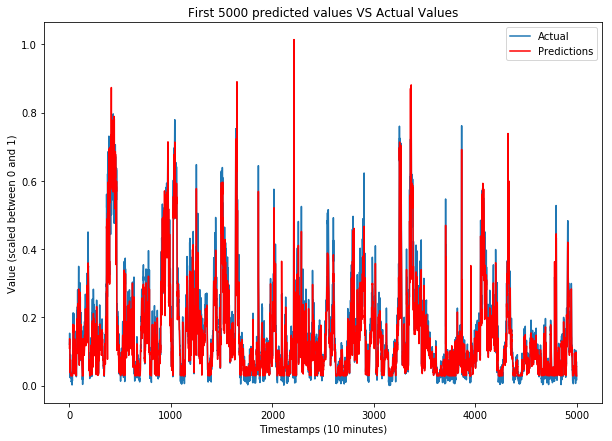

In [60]:
plt.figure(figsize = (10,7))
plt.plot(y_Test_R80790[0:5000], label = 'Actual')
plt.plot(ypred_R80790[0:5000], color='red', label = 'Predictions')
plt.title('First 5000 predicted values VS Actual Values')
plt.legend(loc='best')
plt.xlabel('Timestamps (10 minutes)')
plt.ylabel('Value (scaled between 0 and 1)')
plt.show()

In [20]:
29.37611716/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. +1 CuDNNLSTM

5.427332592694576

In [25]:
25.80995761/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. No diff in time +1 dense

4.76847308954627

In [31]:
25.82544231/(684.15002-142.88750)*100 # Relating the MAE to the IQR for better understanding relative to the data. 15 sec avg diff in time 
                                      # +1 CuDNNLSTM +1 Dense not worth it 310s per epoch

4.7713339379198105